Methods of Machine Learning and Intellectual Analysis of Data (Learning course) \
Bohdan Pavlyshenko (https://www.linkedin.com/in/bpavlyshenko/) \
Youtube video: https://www.youtube.com/watch?v=rVu4surrhbg&list=PLMQt7tnruMvF1jetHNUKjMtHKSp78H2bb&index=19

# Cats vs Dogs Classification (Pytorch, VGG16)

Used resources: \
https://www.kaggle.com/code/bootiu/dog-vs-cat-transfer-learning-vgg16-by-pytorch \
https://www.kaggle.com/code/alpaca0984/dog-vs-cat-with-pytorch \
https://www.kaggle.com/code/douglas426/pytorch-cnn-train-cat-vs-dog-acc-reach-95 \
https://www.kaggle.com/code/fareselmenshawii/introdution-to-transfer-learning \
https://www.doczamora.com/cats-vs-dogs-binary-classifier-with-pytorch-cnn \
https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data \
https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

In [2]:
import copy
import glob
import multiprocessing
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
epochs = 5
num_classes = 2 
batch_size = 64

In [4]:
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]


class CatDogDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label
    

In [5]:
all_files = glob.glob(os.path.join('data', '*.jpg'))

In [11]:
len(all_files)

25000

In [28]:
files_sample=random.sample(all_files, 10000)

In [29]:
train_list, test_list = train_test_split(files_sample, random_state=42)

In [30]:
len(train_list), len(test_list)

(7500, 2500)

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15, 10))
img_files=random.sample(all_files, 6)
for img_path, ax in zip(img_files, axes.ravel()):
    ax.set_title(img_path)
    ax.imshow(Image.open(img_path))

In [32]:
data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [33]:
train_dataset =  CatDogDataset(train_list, transform=data_transforms_train)
test_dataset = CatDogDataset(test_list, transform=data_transforms_test)

train_dl =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [35]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes)
model=model.to(device)

In [36]:
params_to_update = []
for name, param in model.named_parameters():
    if (param.requires_grad == True):
        params_to_update.append(param)
        print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [37]:
len(params_to_update)

32

In [38]:
update_params_name = ['classifier.6.weight', 'classifier.6.bias']
params_to_update = []
for name, param in model.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.6.weight
classifier.6.bias


In [39]:
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.8)
criterion = nn.CrossEntropyLoss()

In [40]:
n_train=len(train_dataset)
n_test=len(test_dataset)

In [41]:
for epoch in range(epochs):
    model.train()
        
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0

    for inputs, labels in tqdm(train_dl):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(outputs, 1)
        train_loss += loss.item()
        train_acc += torch.sum(pred == labels.data).item()
        
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, pred = torch.max(outputs, 1)
            test_loss += loss.item()
            test_acc += torch.sum(pred == labels.data).item()
            
    train_loss = np.round(train_loss / n_train, 5)
    train_acc =  np.round(train_acc / n_train , 5)
    test_loss = np.round(test_loss / n_test, 5)
    test_acc =  np.round(test_acc / n_test, 5)
    print(f'epoch:{epoch+1}, train_loss:{train_loss}, train_acc:{train_acc}, \
test_loss:{test_loss}, test_acc:{test_acc }')

  0%|          | 0/118 [00:00<?, ?it/s]

epoch:1, train_loss:0.00171, train_acc:0.96307, test_loss:0.00081, test_acc:0.9844


  0%|          | 0/118 [00:00<?, ?it/s]

epoch:2, train_loss:0.00091, train_acc:0.98027, test_loss:0.00066, test_acc:0.9876


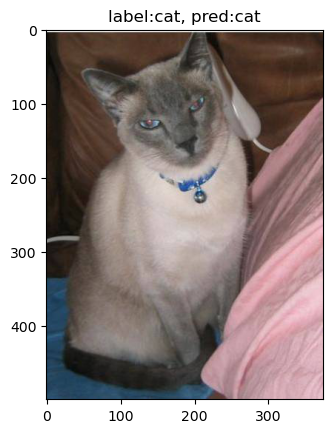

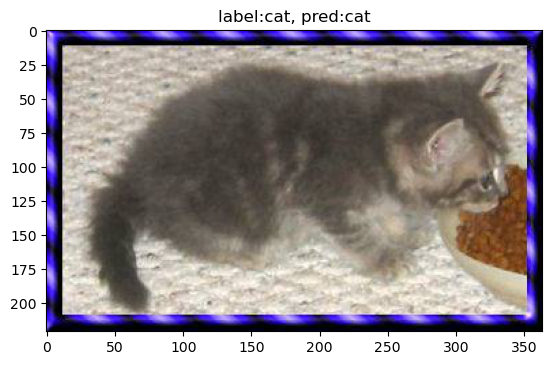

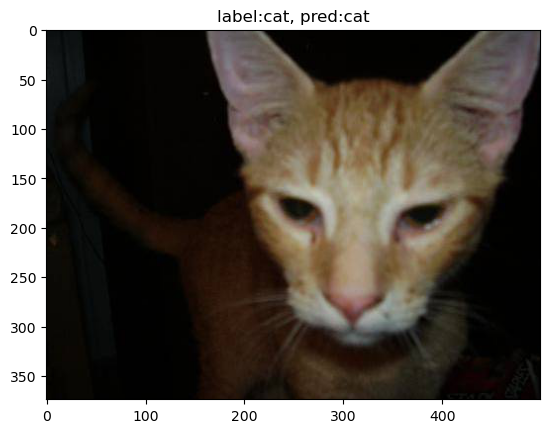

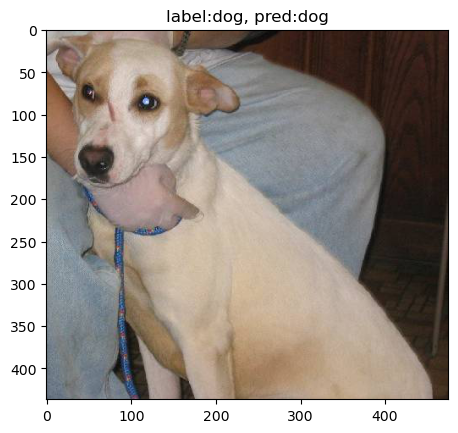

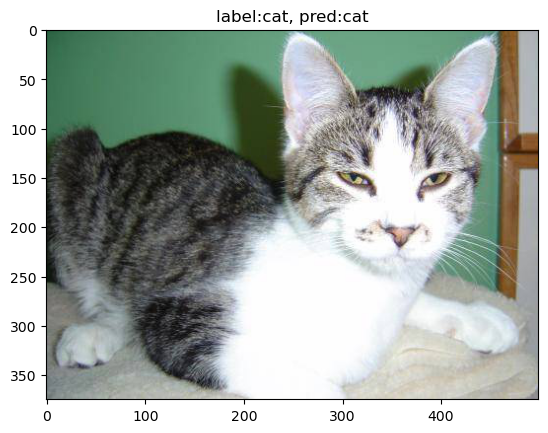

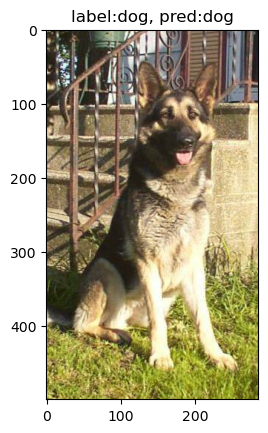

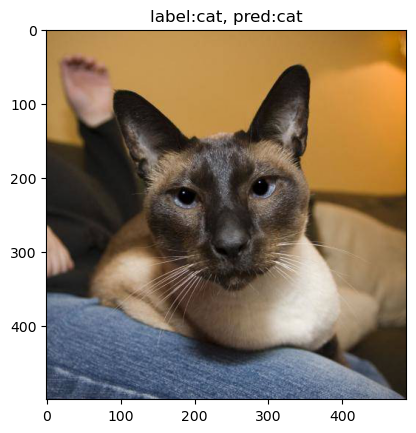

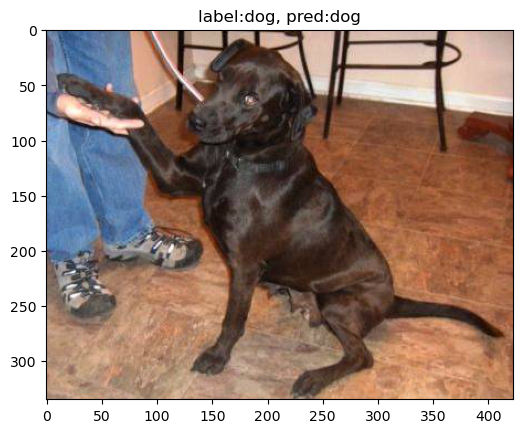

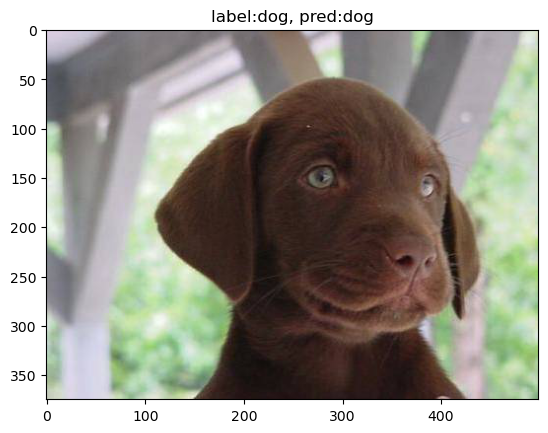

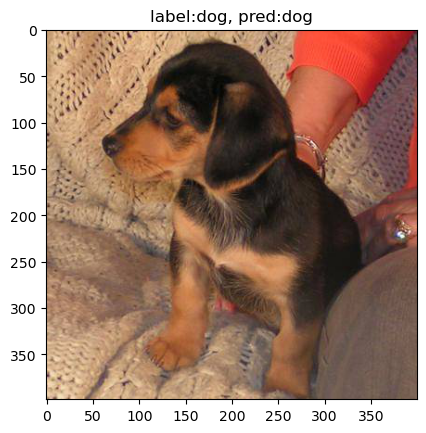

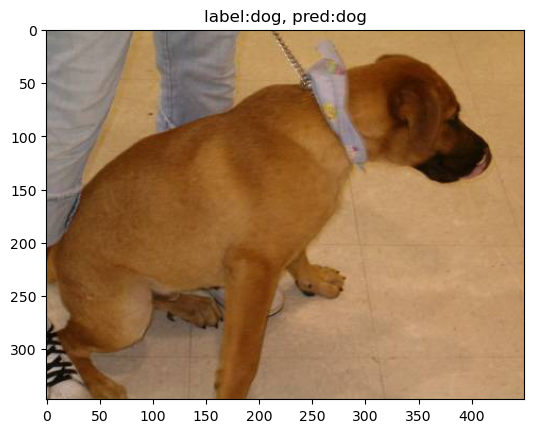

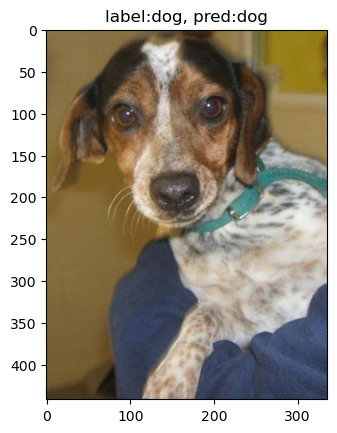

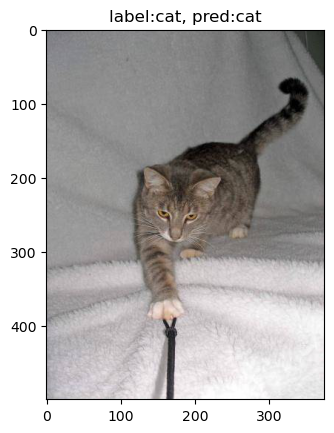

In [42]:
n_results=15

test_data_transform = data_transforms_test

labels = []
preds = []
i=0
model.eval()
with torch.no_grad():
    for test_path in test_list:
        i=i+1
        img = Image.open(test_path)
        img = test_data_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        outputs = model(img)
        pred = F.softmax(outputs, dim=1)[:, 1].tolist()
        pred='dog' if int(round(pred[0]))==1 else 'cat'
        label = extract_class_from(test_path)
        labels.append(label)
        preds.append(pred)
        
        fig = plt.figure()
        ax = fig.add_subplot()
        _=ax.imshow(Image.open(test_path))
        _=ax.set_title(f'label:{label}, pred:{pred}')
    
        if(i>n_results):
            break